In [1]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#### Load up the dataset, tune parameters for the base classifiers

The ID refers to the ID in the UCI database -- i.e., https://archive.ics.uci.edu/dataset/863/maternal+health+risk

In [2]:
from src.data import load_dataset
from sklearn.preprocessing import LabelEncoder


dataset_id = 863
column_names = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X, y = load_dataset(dataset_id)
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
## Include this in the Final version of the demo? The optimization history plot is interesting
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# 
# from xgboost import XGBClassifier
# from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
# from optuna.samplers import TPESampler
# 
# def fn(trial):
#     max_depth = trial.suggest_int("max_depth", low=4, high=128)
#     min_child_weight = trial.suggest_float("min_child_weight", low=0, high=4)
#     gamma = trial.suggest_float("gamma", low=0, high=4)
#     xgb = XGBClassifier(
#         max_depth=max_depth,
#         min_child_weight=min_child_weight,
#         gamma=gamma,
#         random_state=0,
#     )
#     cv = RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0)
#     return cross_val_score(xgb, X, y, cv=cv).mean()
# 
# sampler = TPESampler(seed=0)
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(fn, n_trials=500, n_jobs=1, show_progress_bar=True)
# 
# optuna.visualization.plot_optimization_history(study).show()

In [4]:
## But for now....
from src.param_cache import load_xgb_params
xgb_params = load_xgb_params(dataset_id)
xgb_params

{'max_depth': 39,
 'min_child_weight': 0.31366694223668196,
 'gamma': 0.0011806553353583718}

#### Train the glass box + black box models
- Glass box: A decision tree with up to depth 4
- Black box: XGBoost classifier, hyperparameters tuned via Optuna (250 trials)

In [5]:
from functools import partial

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from src.models import tuned_decision_tree_classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

glass_box_fn = partial(tuned_decision_tree_classifier, max_depth=4)
glass_box = glass_box_fn()
glass_box.fit(X_train, y_train)
print('Glass box - Train accuracy: ', glass_box.score(X_train, y_train))
print('Glass box - Test accuracy:  ', glass_box.score(X_test, y_test))

black_box_fn = partial(XGBClassifier, random_state=0, **xgb_params)
black_box = black_box_fn()
black_box.fit(X_train, y_train)

print('Black box - Train accuracy: ', black_box.score(X_train, y_train))
print('Black box - Test accuracy:  ', black_box.score(X_test, y_test))

Glass box - Train accuracy:  0.7003699136868065
Glass box - Test accuracy:   0.6699507389162561
Black box - Train accuracy:  0.9334155363748459
Black box - Test accuracy:   0.8226600985221675


#### Collect "difficult" training patterns
We want to identify patterns that are,
- Classified correctly by the decision tree ("easy")
- Classified correctly by the random forest, but not the decision tree ("hard")
- Not correctly classified by either ("very hard")
    - This also includes the handful of patterns the decision tree gets right, but not XGBoost

We perform stratified k-fold (4-fold) cross validation on the training set -- i.e. it is split into sub-training (75%) and calibration (25%) data 4 times, with each pattern appearing in the calibration set once. Then, we collate all the patterns which were misclassified when they appeared in the calibration set.

We should expect that this should yield *roughly* (1 - (Testing Accuracy))% of the training set.

e.g. The testing accuracy of the glass box is ~67%, so we can expect ~33% of the training set to get misclassified during the CV.  

In [6]:
from src.experiment import collect_wrong_indices

glass_wrong_idx = collect_wrong_indices(glass_box_fn, X_train, y_train)
print('Ratio of indices "difficult" for glass box: ', len(glass_wrong_idx) / len(X_train))

Ratio of indices "difficult" for glass box:  0.3156596794081381


In [7]:
black_wrong_idx = collect_wrong_indices(black_box_fn, X_train, y_train)
print('Ratio of indices "difficult" for black box: ', len(black_wrong_idx) / len(X_train))

Ratio of indices "difficult" for black box:  0.1504315659679408


Next, sort these patterns into easy/hard/very hard difficulties.

In [8]:
from src.experiment import get_ternary_grader_data

grader_x, grader_y = get_ternary_grader_data(glass_wrong_idx, black_wrong_idx, X_train, skip_oversampling=True)
np.bincount(grader_y) / len(grader_y)

array([0.68434032, 0.22564735, 0.09001233])

66.2% of the patterns are "easy", 21.5% "hard", and 12.2% "very hard".

This kind of imbalanced dataset is difficult to learn from, *especially* when using a shallow decision tree.

We oversample the minority classes using SMOTE in order to get a balanced training set for the grader.

In [9]:
grader_x, grader_y = get_ternary_grader_data(glass_wrong_idx, black_wrong_idx, X_train, skip_oversampling=False)
np.bincount(grader_y) / len(grader_y)

array([0.33333333, 0.33333333, 0.33333333])

In [10]:
grader = glass_box_fn()
grader.fit(grader_x, grader_y);

In [11]:
print(le.inverse_transform([0, 1, 2]))

['high risk' 'low risk' 'mid risk']


## The decision tree for the grader model

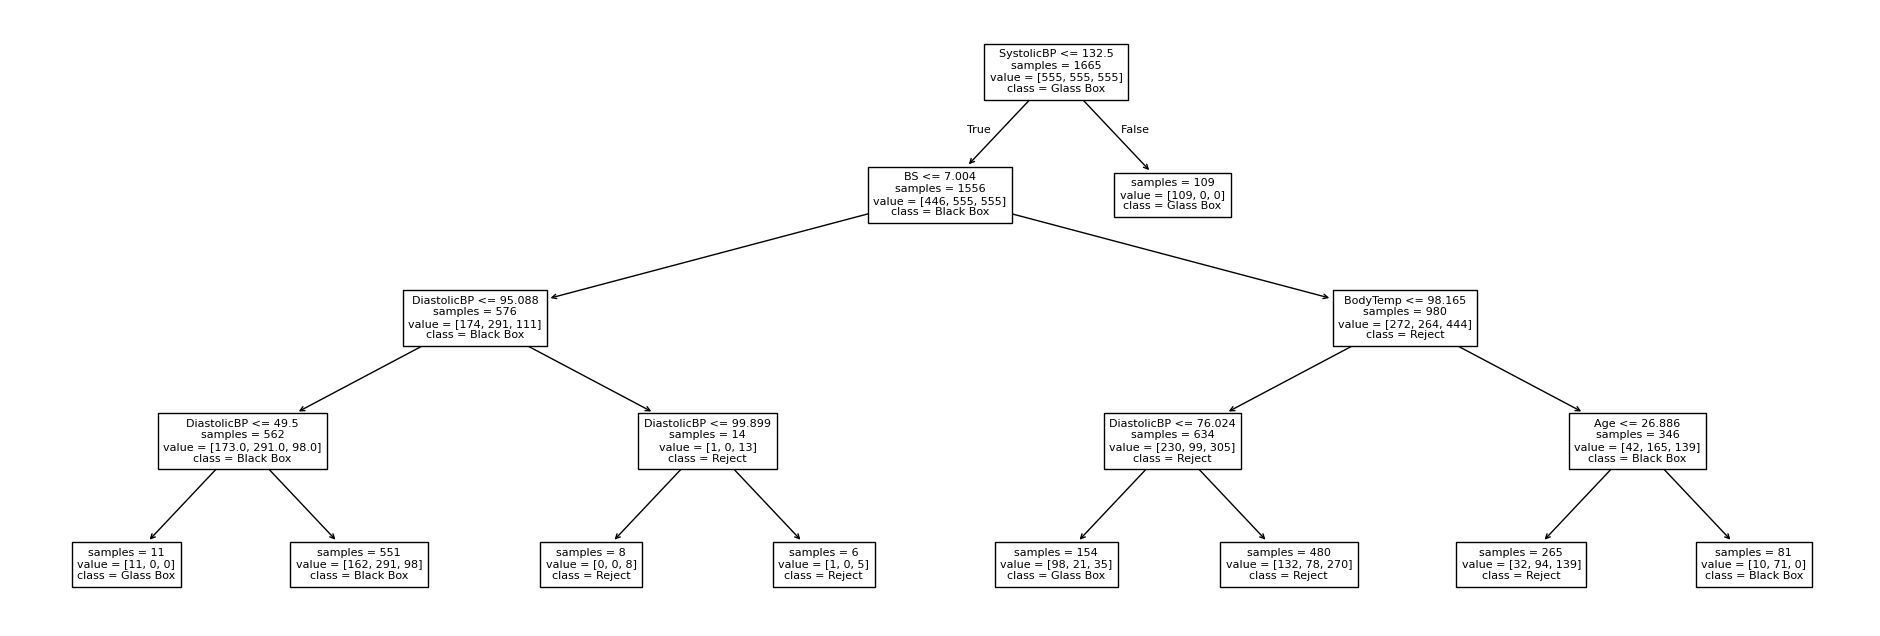

In [12]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(24, 8))
plot_tree(grader.best_estimator_, feature_names=column_names, class_names=['Glass Box', 'Black Box', 'Reject'],
          impurity=False,
          ax=ax, fontsize=8);
plt.show()

## The glass box decision tree

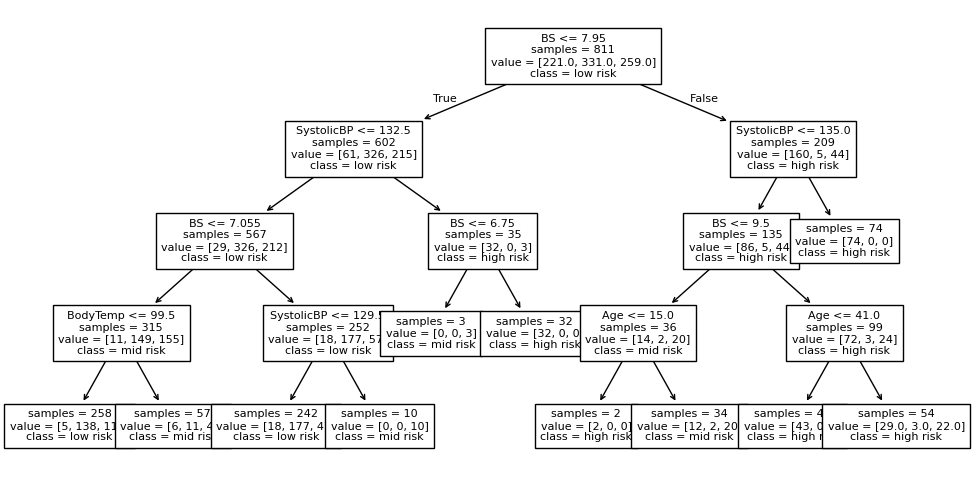

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_tree(glass_box.best_estimator_, feature_names=column_names, class_names=le.inverse_transform(np.arange(3)), ax=ax, fontsize=8, impurity=False)
plt.show()

In [14]:
from src.reporting import parse_results_df, results_dict_to_text
df_train = pd.DataFrame(data={
    'y_truth': y_train,
    'y_glass': glass_box.predict(X_train),
    'y_black': black_box.predict(X_train),
    'y_grader': grader.predict(X_train),
})
df_test = pd.DataFrame(data={
    'y_truth': y_test,
    'y_glass': glass_box.predict(X_test),
    'y_black': black_box.predict(X_test),
    'y_grader': grader.predict(X_test),
})

In [15]:
print('---TRAIN---')
print(results_dict_to_text(parse_results_df(df_train)))

---TRAIN---
  Pattern Allocation
|| Easy       || Hard       || Very Hard  ||
||----------------------------------------||
|| 28.61%     || 39.58%     || 31.81%     ||
||----------------------------------------||

  Accuracy
||            || Overall    || Easy       || Hard       || Very Hard  ||
||------------||------------||------------||------------||------------||
|| Hybrid     || 93.31%     || 92.67%     || 93.77%     || (N/A)      ||
|| Glass Box  || 70.04%     || 92.67%     || 53.58%     || 70.16%     ||
|| Black Box  || 93.34%     || 99.14%     || 93.77%     || 87.60%     ||
||------------||------------||------------||------------||------------||




In [16]:
print('---TEST---')
print(results_dict_to_text(parse_results_df(df_test)))

---TEST---
  Pattern Allocation
|| Easy       || Hard       || Very Hard  ||
||----------------------------------------||
|| 27.59%     || 39.90%     || 32.51%     ||
||----------------------------------------||

  Accuracy
||            || Overall    || Easy       || Hard       || Very Hard  ||
||------------||------------||------------||------------||------------||
|| Hybrid     || 88.32%     || 94.64%     || 83.95%     || (N/A)      ||
|| Glass Box  || 67.00%     || 94.64%     || 46.91%     || 68.18%     ||
|| Black Box  || 82.27%     || 96.43%     || 83.95%     || 68.18%     ||
||------------||------------||------------||------------||------------||




In [121]:
TRAINING_SET, TESTING_SET = 0, 1
DIFF_EASY, DIFF_HARD, DIFF_V_HARD = 0, 1, 2
test_grader_max_depth = 20

In [122]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# 
# 
# difficulty_distribution = np.empty(shape=(50, test_grader_max_depth + 1, 2, 3)) ## split idx, grader depth, train/test, easy/hard/very hard
# final_accuracy_scores = np.empty(shape=(50, test_grader_max_depth + 1, 2))      ## split idx, grader depth, train/test
# glass_box_accuracy = np.empty(shape=(50, test_grader_max_depth + 1,2, 3))       ## split idx, grader depth, train/test, easy/hard/very hard
# black_box_accuracy = np.empty(shape=(50, test_grader_max_depth + 1,2, 3))       ## split idx, grader depth, train/test, easy/hard/very hard
# 
# rskf = RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=0)
# for data_split_idx, (train_index, test_index) in enumerate(rskf.split(X, y)):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
# 
#     glass_box = glass_box_fn()
#     glass_box.fit(X_train, y_train)
#     
#     black_box = black_box_fn()
#     black_box.fit(X_train, y_train)
# 
#     for i in range(2, test_grader_max_depth + 1):
#         grader_fn = partial(tuned_decision_tree_classifier, max_depth=i)
#         grader = grader_fn()
#         grader.fit(grader_x, grader_y)
#         df_train = pd.DataFrame(data={
#             'y_truth': y_train,
#             'y_glass': glass_box.predict(X_train),
#             'y_black': black_box.predict(X_train),
#             'y_grader': grader.predict(X_train),
#         })
#         results_train = parse_results_df(df_train)
#         difficulty_distribution[data_split_idx, i, TRAINING_SET, 0] = results_train['n_easy']
#         difficulty_distribution[data_split_idx, i, TRAINING_SET, 1] = results_train['n_hard']
#         difficulty_distribution[data_split_idx, i, TRAINING_SET, 2] = results_train['n_very_hard']
#         final_accuracy_scores[data_split_idx, i, TRAINING_SET] = results_train['hybrid_n_correct_total'] / (results_train['n_total'] - results_train['n_very_hard'])
#         glass_box_accuracy[data_split_idx, i, TRAINING_SET, 0] = results_train['glass_n_correct_easy'] / results_train['n_easy']
#         glass_box_accuracy[data_split_idx, i, TRAINING_SET, 1] = results_train['glass_n_correct_hard'] / results_train['n_hard']
#         glass_box_accuracy[data_split_idx, i, TRAINING_SET, 2] = results_train['glass_n_correct_very_hard'] / results_train['n_very_hard']
#         black_box_accuracy[data_split_idx, i, TRAINING_SET, 0] = results_train['black_n_correct_easy'] / results_train['n_easy']
#         black_box_accuracy[data_split_idx, i, TRAINING_SET, 1] = results_train['black_n_correct_hard'] / results_train['n_hard']
#         black_box_accuracy[data_split_idx, i, TRAINING_SET, 2] = results_train['black_n_correct_very_hard'] / results_train['n_very_hard']
#     
#         df_test = pd.DataFrame(data={
#             'y_truth': y_test,
#             'y_glass': glass_box.predict(X_test),
#             'y_black': black_box.predict(X_test),
#             'y_grader': grader.predict(X_test),
#         })
#         results_test = parse_results_df(df_test)
#         difficulty_distribution[data_split_idx, i, TESTING_SET, 0] = results_test['n_easy']
#         difficulty_distribution[data_split_idx, i, TESTING_SET, 1] = results_test['n_hard']
#         difficulty_distribution[data_split_idx, i, TESTING_SET, 2] = results_test['n_very_hard']
#         final_accuracy_scores[data_split_idx, i, TESTING_SET] = results_test['hybrid_n_correct_total'] / (results_test['n_total'] - results_test['n_very_hard'])
#         glass_box_accuracy[data_split_idx, i, TESTING_SET, 0] = results_test['glass_n_correct_easy'] / results_test['n_easy']
#         glass_box_accuracy[data_split_idx, i, TESTING_SET, 1] = results_test['glass_n_correct_hard'] / results_test['n_hard']
#         glass_box_accuracy[data_split_idx, i, TESTING_SET, 2] = results_test['glass_n_correct_very_hard'] / results_test['n_very_hard']
#         black_box_accuracy[data_split_idx, i, TESTING_SET, 0] = results_test['black_n_correct_easy'] / results_test['n_easy']
#         black_box_accuracy[data_split_idx, i, TESTING_SET, 1] = results_test['black_n_correct_hard'] / results_test['n_hard']
#         black_box_accuracy[data_split_idx, i, TESTING_SET, 2] = results_test['black_n_correct_very_hard'] / results_test['n_very_hard']
#         
# difficulty_distribution.shape

In [123]:
# np.save("difficulty_distribution.npy", difficulty_distribution)
# np.save("final_accuracy_scores.npy", final_accuracy_scores)
# np.save("glass_box_accuracy.npy", glass_box_accuracy)
# np.save("black_box_accuracy.npy", black_box_accuracy)

In [124]:
difficulty_distribution = np.load("difficulty_distribution.npy")
final_accuracy_scores = np.load("final_accuracy_scores.npy")
glass_box_accuracy = np.load("glass_box_accuracy.npy")
black_box_accuracy = np.load("black_box_accuracy.npy")

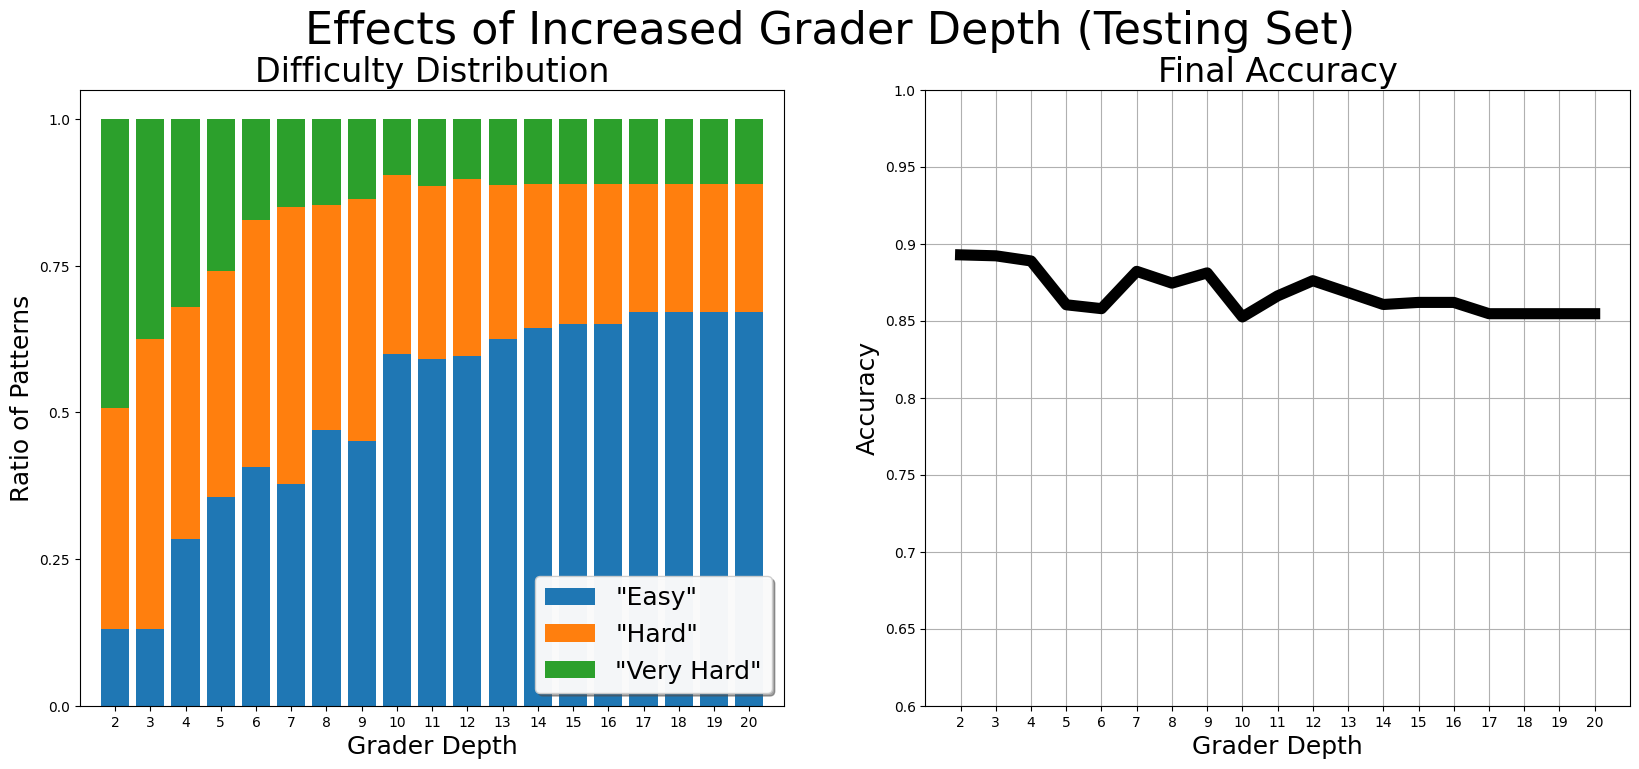

In [125]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
fig.suptitle('Effects of Increased Grader Depth (Testing Set)', fontsize=32)

final_accuracy_mean = final_accuracy_scores.mean(axis=0)
difficulty_ratios_test = (difficulty_distribution.mean(axis=0) / (X.shape[0] * 0.1))[:, TESTING_SET, :]

### Left hand side
categories = np.arange(test_grader_max_depth + 1)
easy = difficulty_ratios_test[2:, 0]
hard = difficulty_ratios_test[2:, 1]
vhard = difficulty_ratios_test[2:, 2]
x = np.arange(2, test_grader_max_depth + 1)

ax[0].bar(x, easy, label='"Easy"')
ax[0].bar(x, hard, bottom=easy, label='"Hard"')
ax[0].bar(x, vhard, bottom=np.array(easy) + np.array(hard), label='"Very Hard"')
ax[0].legend(fontsize=18, framealpha=0.95, shadow=True, loc='lower right')
ax[0].set_title('Difficulty Distribution', fontsize=24)

ax[0].set_xlim(1, test_grader_max_depth + 1)
ax[0].set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax[0].set_xlabel('Grader Depth', fontsize=18)

ax[0].set_yticks(np.linspace(0, 1.0, 5), np.linspace(0.0, 1.0, 5))
ax[0].set_ylabel('Ratio of Patterns', fontsize=18)

### Right hand side
ax[1].plot(np.arange(2, test_grader_max_depth + 1), final_accuracy_mean[2:, TESTING_SET], linewidth=8, color='k')

ax[1].set_xlim(1, test_grader_max_depth + 1)
ax[1].set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax[1].set_xlabel('Grader Depth', fontsize=18)

ax[1].set_ylim(0.6, 1.0)
ax[1].grid()
ax[1].set_yticks(np.linspace(0.6, 1.0, 9), np.linspace(0.6, 1.0, 9))
ax[1].set_ylabel('Accuracy', fontsize=18)
ax[1].set_title('Final Accuracy', fontsize=24)

plt.show()

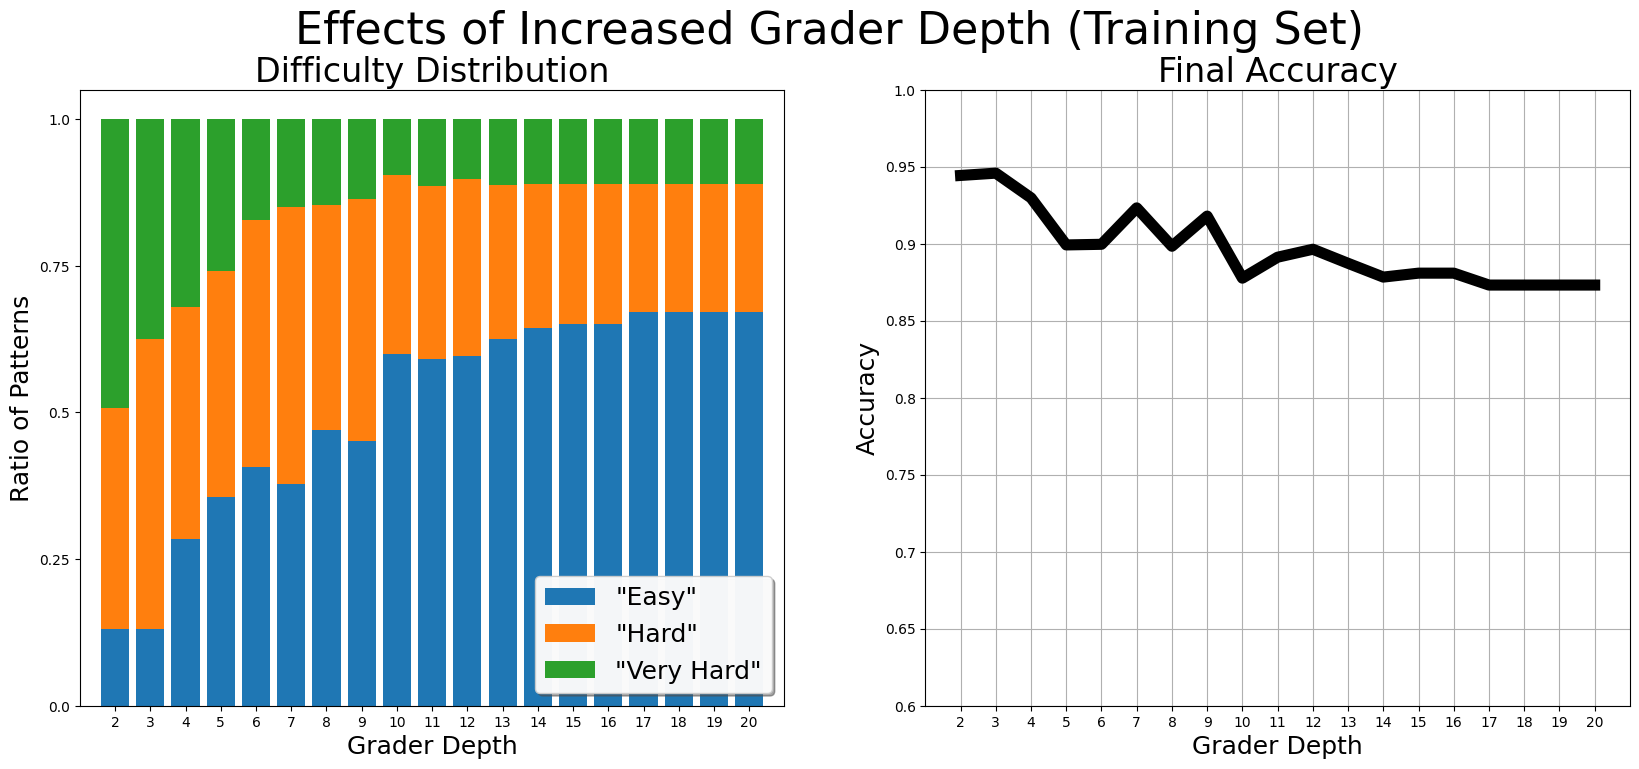

In [126]:

fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
fig.suptitle('Effects of Increased Grader Depth (Training Set)', fontsize=32)

final_accuracy_mean = final_accuracy_scores.mean(axis=0)
difficulty_ratios_train = (difficulty_distribution.mean(axis=0) / (X.shape[0] * 0.9))[:, TRAINING_SET, :]

### Left hand side
categories = np.arange(test_grader_max_depth + 1)
easy = difficulty_ratios_train[2:, 0]
hard = difficulty_ratios_train[2:, 1]
vhard = difficulty_ratios_train[2:, 2]
x = np.arange(2, test_grader_max_depth + 1)

ax[0].bar(x, easy, label='"Easy"')
ax[0].bar(x, hard, bottom=easy, label='"Hard"')
ax[0].bar(x, vhard, bottom=np.array(easy) + np.array(hard), label='"Very Hard"')
ax[0].legend(fontsize=18, framealpha=0.95, shadow=True, loc='lower right')
ax[0].set_title('Difficulty Distribution', fontsize=24)

ax[0].set_xlim(1, test_grader_max_depth + 1)
ax[0].set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax[0].set_xlabel('Grader Depth', fontsize=18)

ax[0].set_yticks(np.linspace(0, 1.0, 5), np.linspace(0.0, 1.0, 5))
ax[0].set_ylabel('Ratio of Patterns', fontsize=18)

### Right hand side
ax[1].plot(np.arange(2, test_grader_max_depth + 1), final_accuracy_mean[2:, TRAINING_SET], linewidth=8, color='k')

ax[1].set_xlim(1, test_grader_max_depth + 1)
ax[1].set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax[1].set_xlabel('Grader Depth', fontsize=18)

ax[1].set_ylim(0.6, 1.0)
ax[1].grid()
ax[1].set_yticks(np.linspace(0.6, 1.0, 9), np.linspace(0.6, 1.0, 9))
ax[1].set_ylabel('Accuracy', fontsize=18)
ax[1].set_title('Final Accuracy', fontsize=24)

plt.show()

In [44]:
## What we also want to see....
# Accuracy of glass box on easy/hard/vhard
# Accuracy of 
#glass_box_accuracy = np.empty(shape=(50, test_grader_max_depth + 1,2, 3))       ## split idx, grader depth, train/test, easy/hard/very hard
glass_box_accuracy[:, 4, 0, 0].mean()

np.float64(0.9275505459447418)

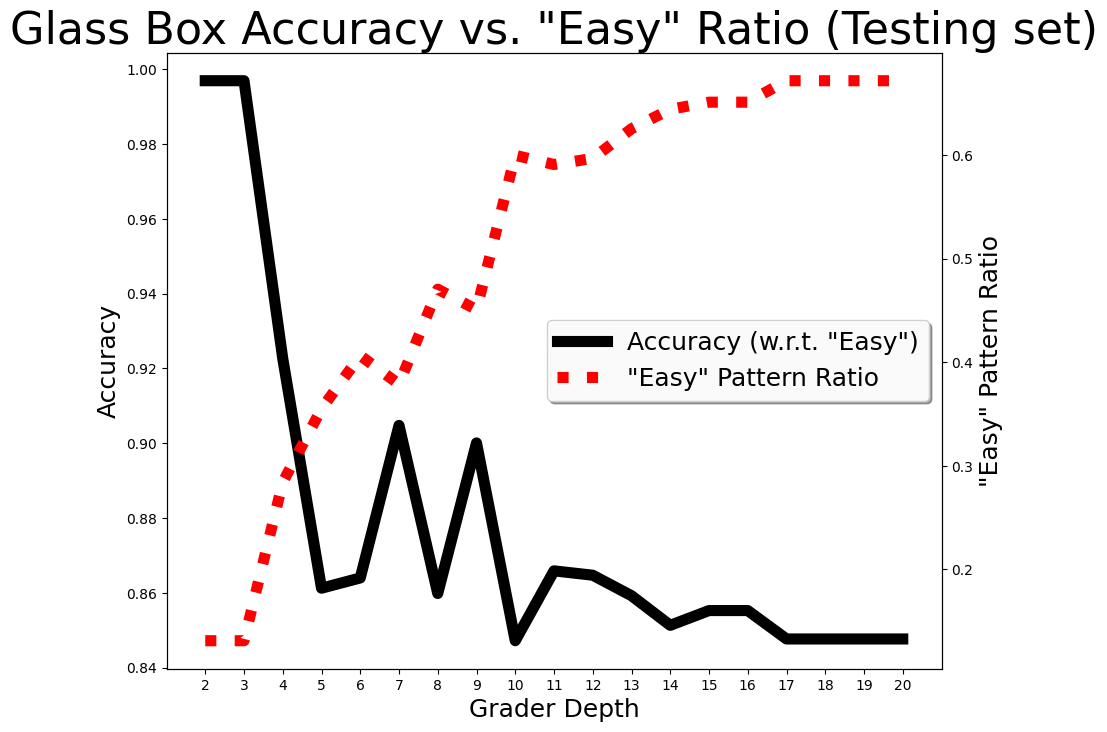

In [127]:
fig, ax = plt.subplots(figsize=(10, 8))
ln1 = ax.plot(np.arange(2, test_grader_max_depth + 1), glass_box_accuracy.mean(axis=0)[2:, TESTING_SET, 0],
              color='k', linewidth=8, label='Accuracy (w.r.t. "Easy")')
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_xlim(1, test_grader_max_depth + 1)
ax.set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax.set_xlabel('Grader Depth', fontsize=18)

right_ax = ax.twinx()
ln2 = right_ax.plot(np.arange(2, test_grader_max_depth + 1), difficulty_ratios_test[2:, 0],
                    color='red', linewidth=8, linestyle=':', label='"Easy" Pattern Ratio')
right_ax.set_ylabel('"Easy" Pattern Ratio', fontsize=18)

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
lg = ax.legend(lns, labels, fontsize=18, framealpha=0.95, shadow=True, loc='center right')
lg.set_zorder(10)

ax.set_title('Glass Box Accuracy vs. "Easy" Ratio (Testing set)', fontsize=32)

plt.show()

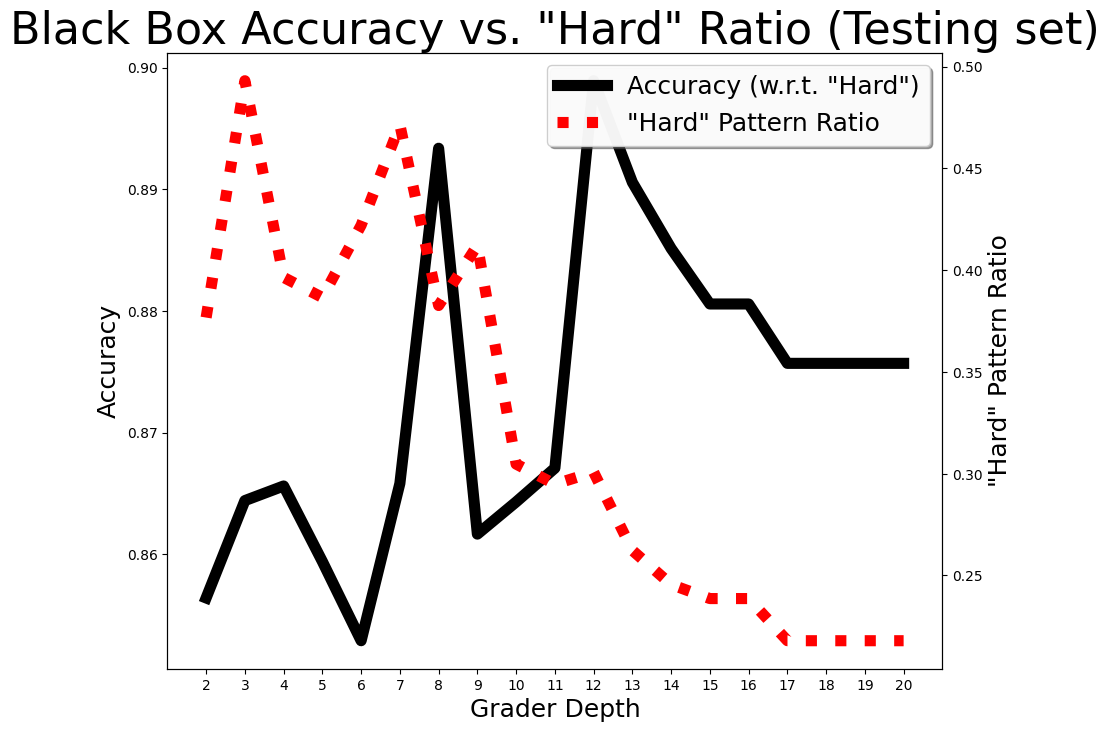

In [129]:
fig, ax = plt.subplots(figsize=(10, 8))
ln1 = ax.plot(np.arange(2, test_grader_max_depth + 1), black_box_accuracy.mean(axis=0)[2:, TESTING_SET, DIFF_HARD],
              color='k', linewidth=8, label='Accuracy (w.r.t. "Hard")')
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_xlim(1, test_grader_max_depth + 1)
ax.set_xticks(np.arange(2, test_grader_max_depth + 1), np.arange(2, test_grader_max_depth + 1))
ax.set_xlabel('Grader Depth', fontsize=18)

right_ax = ax.twinx()
ln2 = right_ax.plot(np.arange(2, test_grader_max_depth + 1), difficulty_ratios_test[2:, DIFF_HARD],
                    color='red', linewidth=8, linestyle=':', label='"Hard" Pattern Ratio')
right_ax.set_ylabel('"Hard" Pattern Ratio', fontsize=18)

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
lg = ax.legend(lns, labels, fontsize=18, framealpha=0.95, shadow=True, loc='upper right')

ax.set_title('Black Box Accuracy vs. "Hard" Ratio (Testing set)', fontsize=32)

plt.show()

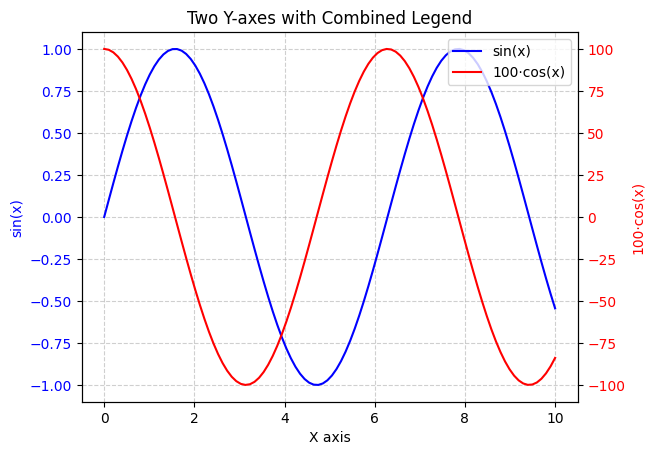

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = 100 * np.cos(x)

# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot on first y-axis
ln1 = ax1.plot(x, y1, color='b', label="sin(x)")
ax1.set_xlabel("X axis")
ax1.set_ylabel("sin(x)", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis
ax2 = ax1.twinx()
ln2 = ax2.plot(x, y2, color='r', label="100·cos(x)")
ax2.set_ylabel("100·cos(x)", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc="upper right")

# Optional grid
ax1.grid(True, linestyle='--', alpha=0.6)

plt.title("Two Y-axes with Combined Legend")
plt.show()